In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.functional import F
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from rnn_seq2seq import RNNSeq2Seq

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

2025-05-27 19:45:34.957256: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 19:45:34.964597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748364334.972781   42241 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748364334.975247   42241 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748364334.981628   42241 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data = pd.read_csv('Reviews.csv', nrows=100000)

In [3]:
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                       "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [5]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [6]:
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    new_string = text.lower()
    new_string = BeautifulSoup(new_string, 'lxml').text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"', '', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    tokens = [w for w in new_string.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:
            long_words.append(i)
    return (" ".join(long_words)).strip()


cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [7]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [8]:
def summary_cleaner(text):
    new_string = re.sub('"', '', text)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    new_string = new_string.lower()
    tokens = new_string.split()
    new_string = ''
    for i in tokens:
        if len(i) > 1:
            new_string = new_string + i + ' '
    return new_string


cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [9]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

In [11]:
for i in range(5):
    print('Review: ', data['cleaned_text'][i])
    print('Summary: ', data['cleaned_summary'][i])
    print('\n')

Review:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary:  _START_ good quality dog food  _END_


Review:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary:  _START_ not as advertised  _END_


Review:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary:  _START_ delight says it all  _END_


Review:  looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary:  _START_ cough medicine  _END_


Review:  great taffy great price wide assortment yummy taffy delivery quick

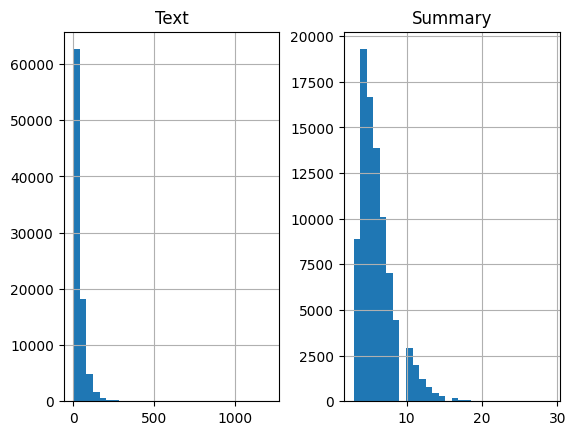

In [12]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text': text_word_count, 'Summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [13]:
max_len_text = 80
max_len_summary = 10

In [14]:
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1,
                                            random_state=0, shuffle=True)

In [15]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

In [16]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

In [17]:
train_data = TensorDataset(torch.from_numpy(x_tr).long(), torch.from_numpy(y_tr).long())
val_data = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=True)

In [18]:
def train_and_validate(model_, optimizer_, criterion_, train_loader_, val_loader_, epochs_, device_):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for (inputs, targets) in train_loader_:
            inputs, targets = inputs.to(device_), targets.to(device_)
            outputs = model_(inputs, targets)
            loss = criterion_(outputs[:, 1:, :].flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
            total_train_loss += loss.item()
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        model_.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader_:
                inputs, targets = inputs.to(device_), targets.to(device_)
                outputs = model_(inputs, targets, 0)
                loss = criterion_(outputs[:, 1:, :].flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
                total_val_loss += loss.item()
                total_val_acc += outputs[:, 1:, :].argmax(dim=-1).eq(targets[:, 1:]).sum().item()

        total_train_loss = total_train_loss / len(train_loader_)
        total_val_loss = total_val_loss / len(val_loader_)
        total_val_acc = total_val_acc / len(val_loader_)

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)
        val_accs.append(total_val_acc)
        print(
            f'Epoch: {epoch + 1} / {epochs_} | Train loss: {total_train_loss} | Val loss: {total_val_loss} | Val acc: {total_val_acc}')
    return train_losses, val_losses, val_accs


In [19]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [20]:
target_word_index = y_tokenizer.word_index
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word

In [21]:
def decode_sequence(input_seq, model_):
    _, hidden = model_.encoder(torch.IntTensor(input_seq).to(device))

    target_seq = torch.zeros(1, dtype=torch.int64).to(device)
    target_seq[0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        embedded_seq = model_.decoder_embedder(target_seq.unsqueeze(1))
        prediction, hidden = model_.decoder(embedded_seq, hidden)
        prediction_index = prediction.argmax(dim=-1)[0].item()
        predicted_word = reverse_target_word_index[prediction_index]

        if predicted_word != 'end':
            decoded_sentence += ' ' + predicted_word

        if predicted_word == 'end' or len(decoded_sentence.split()) >= max_len_summary - 1:
            stop_condition = True

        target_seq = torch.zeros(1, dtype=torch.int64).to(device)
        target_seq[0] = prediction_index

    return decoded_sentence


In [22]:
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string


# RNN Seq2Seq

In [23]:
epochs = 20
embedding_dim = 400
hidden_dim = 256
enc_layers = 3
dec_layers = 3
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [24]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 20 | Train loss: 5.792813873830492 | Val loss: 5.658355944574216 | Val acc: 54.43502824858757
Epoch: 2 / 20 | Train loss: 5.4731684741098725 | Val loss: 5.648339724136611 | Val acc: 54.45762711864407
Epoch: 3 / 20 | Train loss: 5.352104402502553 | Val loss: 5.677078034244688 | Val acc: 54.45762711864407
Epoch: 4 / 20 | Train loss: 5.2630138520097525 | Val loss: 5.649860753851422 | Val acc: 54.91525423728814
Epoch: 5 / 20 | Train loss: 5.2077056395040975 | Val loss: 5.668068691835565 | Val acc: 55.07344632768361
Epoch: 6 / 20 | Train loss: 5.171854757048813 | Val loss: 5.658726533253987 | Val acc: 54.85875706214689
Epoch: 7 / 20 | Train loss: 5.145235453964704 | Val loss: 5.66265813644323 | Val acc: 54.632768361581924
Epoch: 8 / 20 | Train loss: 5.110555103782735 | Val loss: 5.690619242393364 | Val acc: 54.49152542372882
Epoch: 9 / 20 | Train loss: 5.076264438952836 | Val loss: 5.677979084057997 | Val acc: 55.045197740113
Epoch: 10 / 20 | Train loss

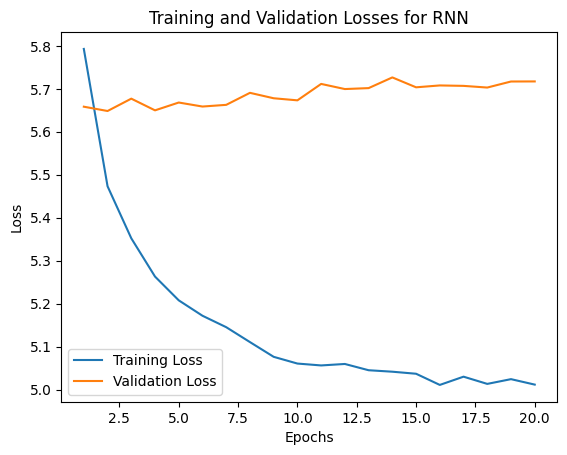

In [25]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [28]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  loves things though think taste nasty hahaha actually learned chew gums matter picky pull eat know carbs best thing least know organic cheese puff buying amazon saved money stores three dollars 
Original summary:  this is my daughter favorite snack 
Predicted summary:   the great


# RNN Seq2Seq With Attention

In [31]:
epochs = 20
embedding_dim = 400
hidden_dim = 256
enc_layers = 3
dec_layers = 3
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [32]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 20 | Train loss: 6.01183503652653 | Val loss: 5.734146304049735 | Val acc: 49.93785310734463
Epoch: 2 / 20 | Train loss: 5.801473530338367 | Val loss: 5.736685154801708 | Val acc: 49.644067796610166
Epoch: 3 / 20 | Train loss: 5.70423604466494 | Val loss: 5.591104437402413 | Val acc: 48.50847457627118
Epoch: 4 / 20 | Train loss: 5.609396091427614 | Val loss: 5.617850352141817 | Val acc: 43.3728813559322
Epoch: 5 / 20 | Train loss: 5.549550505122023 | Val loss: 5.534134315232099 | Val acc: 44.64971751412429
Epoch: 6 / 20 | Train loss: 5.512926857550889 | Val loss: 5.497531694207487 | Val acc: 47.38418079096045
Epoch: 7 / 20 | Train loss: 5.480644782334285 | Val loss: 5.470721686627232 | Val acc: 49.54237288135593
Epoch: 8 / 20 | Train loss: 5.447627149985917 | Val loss: 5.5922490459377485 | Val acc: 32.19209039548023
Epoch: 9 / 20 | Train loss: 5.422263556048227 | Val loss: 5.479984903066172 | Val acc: 46.71186440677966
Epoch: 10 / 20 | Train loss: 

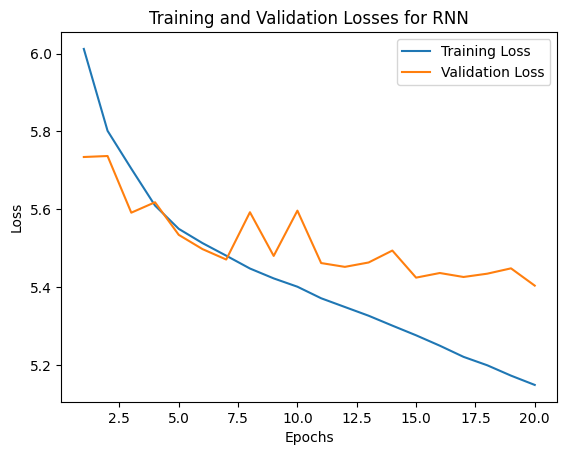

In [33]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [34]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  loves things though think taste nasty hahaha actually learned chew gums matter picky pull eat know carbs best thing least know organic cheese puff buying amazon saved money stores three dollars 
Original summary:  this is my daughter favorite snack 
Predicted summary:   my dogs great great great great great great great


# RNN Seq2Seq With Attention and BiDirectional Encoder

In [23]:
epochs = 20
embedding_dim = 400
hidden_dim = 256
enc_layers = 3
dec_layers = 3
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [24]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 20 | Train loss: 6.017148529187004 | Val loss: 5.743007083397127 | Val acc: 49.93785310734463
Epoch: 2 / 20 | Train loss: 5.853603598009034 | Val loss: 5.701917723747297 | Val acc: 49.93785310734463
Epoch: 3 / 20 | Train loss: 5.801901766670942 | Val loss: 5.688819785576082 | Val acc: 49.717514124293785
Epoch: 4 / 20 | Train loss: 5.742026683596378 | Val loss: 5.603056525106484 | Val acc: 49.93785310734463
Epoch: 5 / 20 | Train loss: 5.703498501660762 | Val loss: 5.583811129553843 | Val acc: 49.932203389830505
Epoch: 6 / 20 | Train loss: 5.673774333512686 | Val loss: 5.569572195494916 | Val acc: 49.92655367231639
Epoch: 7 / 20 | Train loss: 5.611719574439758 | Val loss: 5.67933785174526 | Val acc: 28.050847457627118
Epoch: 8 / 20 | Train loss: 5.528154606042906 | Val loss: 5.481837762951177 | Val acc: 45.85310734463277
Epoch: 9 / 20 | Train loss: 5.482263423301078 | Val loss: 5.451216708468852 | Val acc: 48.97175141242938
Epoch: 10 / 20 | Train los

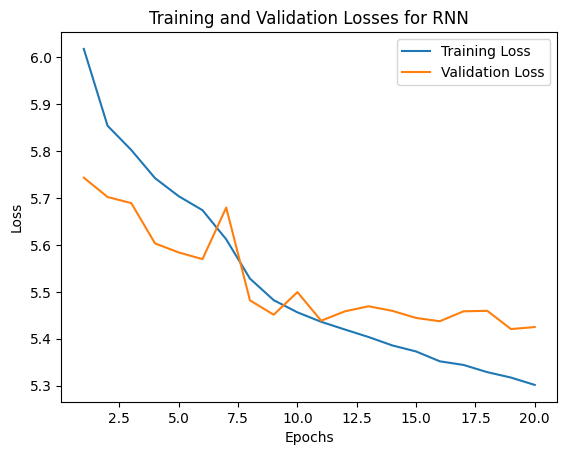

In [25]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [26]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  loves things though think taste nasty hahaha actually learned chew gums matter picky pull eat know carbs best thing least know organic cheese puff buying amazon saved money stores three dollars 
Original summary:  this is my daughter favorite snack 
Predicted summary:   deboles shepard detailed great great great great great great
